In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# preprocess the data
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data
y_train_cat = to_categorical(y_train)  # One-hot encoding
y_test_cat = to_categorical(y_test)

# simple neural network model
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
def select_indices_based_on_vulnerability_analysis(predictions, y_true, threshold=0.9):
    """
    Select indices of instances based on the model vulnerabilities.

    Parameters:
    predictions: The model probabilities.
    y_true: The true labels.
    threshold: threshold to consider an instance for label flipping.

    Returns:
    A list of indices that are considered vulnerable.
    """
    vulnerable_indices = []
    confidence_scores = np.max(predictions, axis=1)

    # Select instances where the model is highly confident but wrong
    for i, (score, prediction, true_label) in enumerate(zip(confidence_scores, np.argmax(predictions, axis=1), y_true)):
        if score > threshold and prediction != true_label:
            vulnerable_indices.append(i)

    return vulnerable_indices


In [ ]:
 # select the least likely class
def manipulate_labels_at_least_likely(y_train, predictions):
    y_manipulated = y_train.copy()
    for i, prediction in enumerate(predictions):
        least_likely_class = np.argmin(prediction)
        y_manipulated[i] = least_likely_class
    return y_manipulated

In [ ]:

# percentages of labels to manipulate
percentages = [0.1, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.98]



initial_epochs = 5
manipulated_epochs = 5

model = create_model()

# simulating training the model
model.fit(x_train, y_train_cat, epochs=initial_epochs, validation_split=0.2, verbose=0)

# baseline accuracy
baseline_accuracy = model.evaluate(x_test, y_test_cat, verbose=0)[1]

# storing accuracies after manipulation
manipulated_accuracies = []



# Adjust the loop to use the new manipulation function
for percentage in percentages:
    # Generate predictions for the entire training set
    predictions = model.predict(x_train)

    # Manipulate the entire training labels based on the strategy
    manipulated_labels = manipulate_labels_at_least_likely(y_train, predictions)

    # Manipulate a percentage of the training labels
    num_manipulated_samples = int(len(y_train) * percentage)
    indices = np.random.choice(len(y_train), num_manipulated_samples, replace=False)
    y_train_partial_manipulated = np.copy(y_train)
    y_train_partial_manipulated[indices] = manipulated_labels[indices]
    y_train_manipulated_cat = to_categorical(y_train_partial_manipulated)

    # Retrain the model with the manipulated labels
    model_manipulated = create_model()
    manipulated_epochs = 5

    # Train the baseline model
    history = model.fit(x_train, y_train_cat, epochs=5, validation_split=0.2, verbose=2)
    model_manipulated.fit(x_train, y_train_manipulated_cat, epochs=manipulated_epochs, validation_split=0.2, verbose=0)


    # Evaluate the manipulated model
    manipulated_accuracy = model_manipulated.evaluate(x_test, y_test_cat, verbose=0)[1]
    manipulated_accuracies.append(manipulated_accuracy)
    print(f"Accuracy after {percentage*100}% labels manipulated: {manipulated_accuracy*100:.2f}%")
    print(f"Baseline Accuracy: {baseline_accuracy*100:.2f}%")




1875/1875 [==============================] - 3s 1ms/step
Epoch 1/5
1500/1500 - 4s - loss: 0.0400 - accuracy: 0.9875 - val_loss: 0.0863 - val_accuracy: 0.9743 - 4s/epoch - 3ms/step
Epoch 2/5
1500/1500 - 4s - loss: 0.0302 - accuracy: 0.9911 - val_loss: 0.0898 - val_accuracy: 0.9741 - 4s/epoch - 3ms/step
Epoch 3/5
1500/1500 - 4s - loss: 0.0252 - accuracy: 0.9928 - val_loss: 0.0891 - val_accuracy: 0.9747 - 4s/epoch - 3ms/step
Epoch 4/5
1500/1500 - 4s - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.1001 - val_accuracy: 0.9730 - 4s/epoch - 2ms/step
Epoch 5/5
1500/1500 - 4s - loss: 0.0174 - accuracy: 0.9943 - val_loss: 0.0942 - val_accuracy: 0.9744 - 4s/epoch - 3ms/step
Accuracy after 10.0% labels manipulated: 95.39%
Baseline Accuracy: 97.50%
1875/1875 [==============================] - 3s 1ms/step
Epoch 1/5
1500/1500 - 5s - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0941 - val_accuracy: 0.9753 - 5s/epoch - 3ms/step
Epoch 2/5
1500/1500 - 4s - loss: 0.0124 - accuracy: 0.9967 - val_loss: 0.0

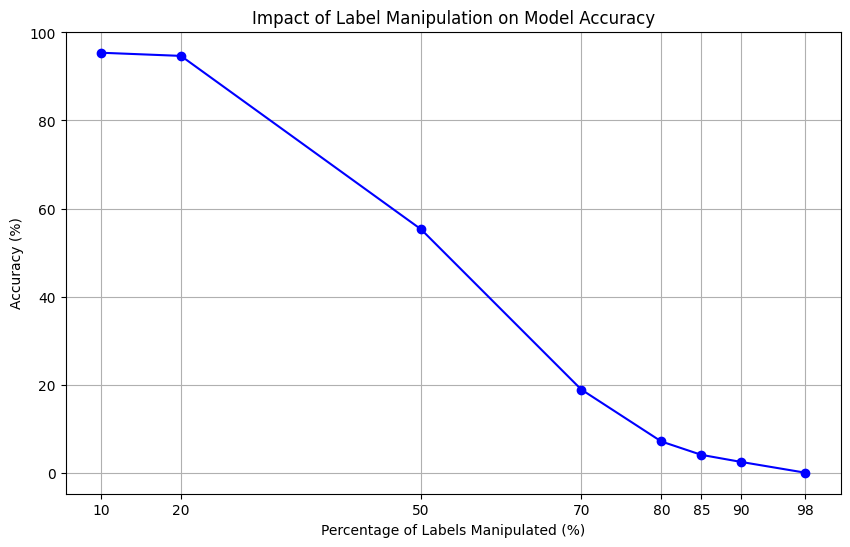

In [ ]:
# Plotting of label manipulation on model accuracy
plt.figure(figsize=(10, 6))
plt.plot([p*100 for p in percentages], [acc*100 for acc in manipulated_accuracies], marker='o', linestyle='-', color='blue')
plt.title('Impact of Label Manipulation on Model Accuracy')
plt.xlabel('Percentage of Labels Manipulated (%)')
plt.ylabel('Accuracy (%)')
plt.xticks([p*100 for p in percentages])
plt.grid(True)
plt.show()